In [43]:
import os
import shutil
import copy
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import seaborn as sns
import torch
from torchvision import datasets , transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split, Subset
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

**A dataset analysis was done in the previous task.**

In [2]:
src_path = "/kaggle/input/animals10/raw-img"
path = "/kaggle/working/raw-img"

shutil.copytree(src_path, path, dirs_exist_ok=True)

'/kaggle/working/raw-img'

In [3]:
translate = {"cane": "dog", "cavallo": "horse", "elefante": "elephant",
             "farfalla": "butterfly", "gallina": "chicken", "gatto": "cat",
             "mucca": "cow", "pecora": "sheep", "scoiattolo": "squirrel", "ragno": "spider"}
classes = os.listdir(path)

In [4]:
for category in classes:
    category_path = os.path.join(path, category)
    if os.path.isdir(category_path):
        eng_name = translate.get(category, category)
        eng_path = os.path.join(path, eng_name)
        if eng_name != category:
            os.rename(category_path, eng_path)

In [5]:
transform_data_train = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_data_test = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [27]:
dataset = datasets.ImageFolder(root=path)
print(dataset)

Dataset ImageFolder
    Number of datapoints: 26179
    Root location: /kaggle/working/raw-img


In [28]:
dataset_size = len(dataset)
train_size = int(0.7 * dataset_size)
test_size = int(0.2 * dataset_size)
val_size = dataset_size - train_size - test_size

In [30]:
train_indices, test_indices, val_indices = random_split(
    range(len(dataset)), [train_size, test_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

train_dataset = Subset(datasets.ImageFolder(root=path, transform=transform_data_train), train_indices.indices)
test_dataset = Subset(datasets.ImageFolder(root=path, transform=transform_data_test), test_indices.indices)
val_dataset = Subset(datasets.ImageFolder(root=path, transform=transform_data_test), val_indices.indices)

In [31]:
batch_size = 128

train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_dataset, batch_size=batch_size*2, shuffle=True, num_workers=4, pin_memory=True)
test_dl = DataLoader(test_dataset, batch_size=batch_size*2, shuffle=True, num_workers=4, pin_memory=True)

In [32]:
class ModelCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(ModelCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

        self.conv1x1 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=1)

        self.pool = nn.MaxPool2d(2, 2)

        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)

        self.fc1 = nn.Linear(128 * 28 * 28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc_out = nn.Linear(128, num_classes)
        
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = F.relu(self.conv1x1(x))

        x = torch.flatten(x, 1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc_out(x)

        return x

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [34]:
cnn = ModelCNN().to(device)

In [35]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)

In [36]:
def train_model(model, train_dl, val_dl, device, optimizer, epochs=10):
    loss_function = nn.CrossEntropyLoss()
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_acc = 0.0

    for epoch in range(epochs):
        model.train()
        running_loss, running_corrects = 0.0, 0

        for inputs, labels in train_dl:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item()
            running_corrects += torch.sum(preds == labels.data).item()

        epoch_loss = running_loss / len(train_dl)
        epoch_acc = running_corrects / len(train_dl.dataset)
        history["train_loss"].append(epoch_loss)
        history["train_acc"].append(epoch_acc)

        model.eval()
        val_loss, val_corrects = 0.0, 0
        with torch.no_grad():
            for val_inputs, val_labels in val_dl:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                val_outputs = model(val_inputs)
                loss = loss_function(val_outputs, val_labels)
                _, val_preds = torch.max(val_outputs, 1)
                val_loss += loss.item()
                val_corrects += torch.sum(val_preds == val_labels.data).item()

        val_epoch_loss = val_loss / len(val_dl)
        val_epoch_acc = val_corrects / len(val_dl.dataset)
        history["val_loss"].append(val_epoch_loss)
        history["val_acc"].append(val_epoch_acc)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} | Val Loss: {val_epoch_loss:.4f} | Val Acc: {val_epoch_acc:.4f}")
        
        if val_epoch_acc > best_val_acc:
            best_val_acc = val_epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_model_wts)
    return model, history

In [37]:
trained_model, history = train_model(cnn, train_dl, val_dl, device, optimizer, epochs=30)

Epoch 1/30 | Train Loss: 1.8558 | Train Acc: 0.3655 | Val Loss: 1.4656 | Val Acc: 0.4884
Epoch 2/30 | Train Loss: 1.4070 | Train Acc: 0.5162 | Val Loss: 1.2856 | Val Acc: 0.5659
Epoch 3/30 | Train Loss: 1.2165 | Train Acc: 0.5864 | Val Loss: 1.1459 | Val Acc: 0.6277
Epoch 4/30 | Train Loss: 1.0721 | Train Acc: 0.6345 | Val Loss: 1.1668 | Val Acc: 0.6140
Epoch 5/30 | Train Loss: 0.9734 | Train Acc: 0.6673 | Val Loss: 1.2548 | Val Acc: 0.6052
Epoch 6/30 | Train Loss: 0.8815 | Train Acc: 0.6961 | Val Loss: 1.0849 | Val Acc: 0.6418
Epoch 7/30 | Train Loss: 0.8179 | Train Acc: 0.7231 | Val Loss: 0.9414 | Val Acc: 0.6869
Epoch 8/30 | Train Loss: 0.7475 | Train Acc: 0.7478 | Val Loss: 0.9210 | Val Acc: 0.6972
Epoch 9/30 | Train Loss: 0.6972 | Train Acc: 0.7677 | Val Loss: 0.9661 | Val Acc: 0.7022
Epoch 10/30 | Train Loss: 0.6241 | Train Acc: 0.7890 | Val Loss: 0.9307 | Val Acc: 0.6968
Epoch 11/30 | Train Loss: 0.5758 | Train Acc: 0.8018 | Val Loss: 0.8724 | Val Acc: 0.7083
Epoch 12/30 | Train

In [38]:
def plot_training_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    ax[0].plot(history['train_loss'], label='Train Loss')
    ax[0].plot(history['val_loss'], label='Val Loss')
    ax[0].set_title('Loss per Epoch')
    ax[0].legend()

    ax[1].plot(history['train_acc'], label='Train Acc')
    ax[1].plot(history['val_acc'], label='Val Acc')
    ax[1].set_title('Accuracy per Epoch')
    ax[1].legend()


    plt.show()

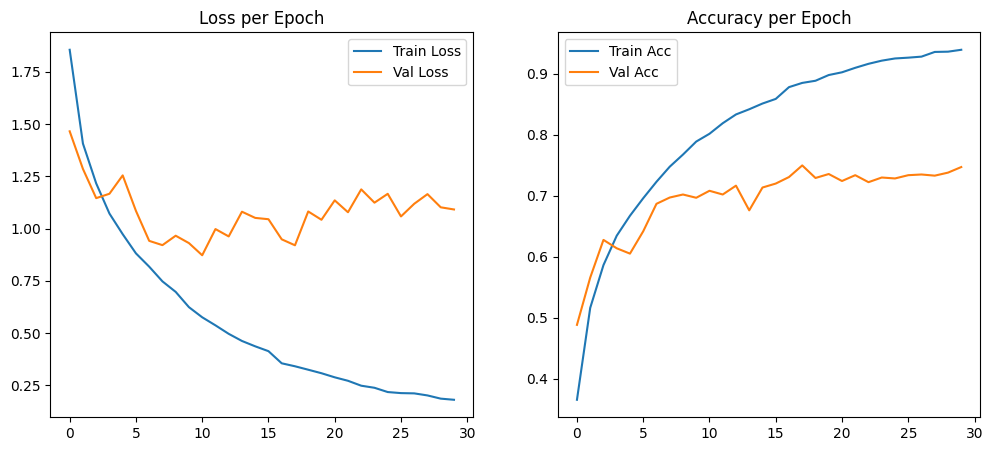

In [39]:
plot_training_history(history)

In [41]:
def evaluate_model(model, test_dl, device):
    model.eval()
    all_preds, all_labels = [], []
    class_names = dataset.classes

    with torch.no_grad():
        for inputs, labels in test_dl:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f"Test Accuracy: {acc:.4f}")
    print(f"F1 Score (weighted): {f1:.4f}")
    
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    cm = confusion_matrix(all_labels, all_preds)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

Test Accuracy: 0.7368
F1 Score (weighted): 0.7352
Classification Report:
              precision    recall  f1-score   support

   butterfly       0.84      0.82      0.83       439
         cat       0.60      0.56      0.58       323
     chicken       0.81      0.78      0.80       597
         cow       0.69      0.50      0.58       386
         dog       0.72      0.73      0.72       941
    elephant       0.62      0.77      0.69       290
       horse       0.71      0.69      0.70       520
       sheep       0.67      0.65      0.66       394
      spider       0.86      0.88      0.87       971
    squirrel       0.63      0.72      0.67       374

    accuracy                           0.74      5235
   macro avg       0.71      0.71      0.71      5235
weighted avg       0.74      0.74      0.74      5235



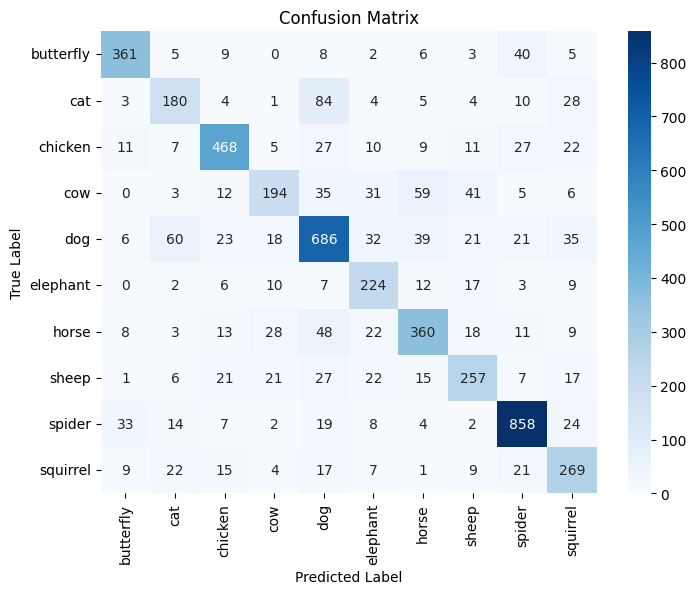

In [44]:
evaluate_model(trained_model, test_dl, device)

In [45]:
def show_misclassified_images(model, dataloader, class_names, device, max_images=10):
    model.eval()
    misclassified_images = []
    misclassified_preds = []
    misclassified_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for img, pred, label in zip(images, preds, labels):
                if pred != label:
                    misclassified_images.append(img.cpu())
                    misclassified_preds.append(pred.cpu())
                    misclassified_labels.append(label.cpu())

                if len(misclassified_images) >= max_images:
                    break
            if len(misclassified_images) >= max_images:
                break

    plt.figure(figsize=(15, 5))
    for i in range(len(misclassified_images)):
        plt.subplot(1, len(misclassified_images), i + 1)
        img = misclassified_images[i].permute(1, 2, 0).numpy()
        img = (img - img.min()) / (img.max() - img.min())
        plt.imshow(img)
        plt.title(f"True: {class_names[misclassified_labels[i]]}\nPred: {class_names[misclassified_preds[i]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

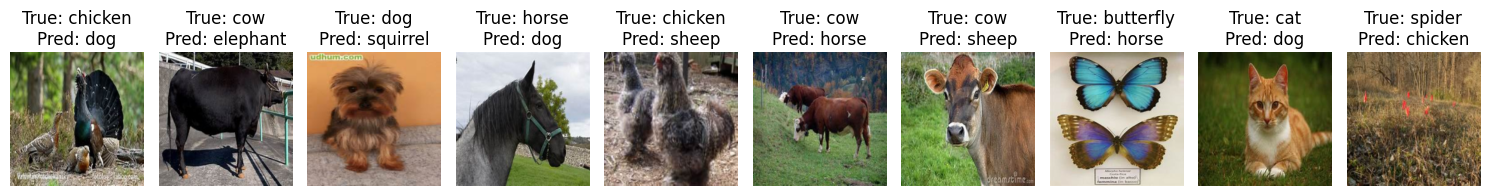

In [46]:
show_misclassified_images(cnn, test_dl, dataset.classes, device)

**Висновок:**

Було побудовано базову cnn модель з такою архітектурою:

**Конволюційні шари:**

Три основні конволюційні шари, які мають ReLU активацію після кожного.

Додатково, використовується 1x1 конволюційний шар для перетворення даних після третього конволюційного шару.

**Пулінг:**
Після кожного конволюційного шару застосовується максімальний пулінг (MaxPool2d), що зменшує просторові розміри зображення вдвічі.

**Нормалізація:**
Для кожного конволюційного шару є BatchNorm.

**Повнозв'язкові шари:**
Після перетворення зображення через конволюційні шари та пулінг, вхід передається через два повнозв'язкові шари (fc1, fc2), які зменшують розмірність.

**Вихідний шар:**
Останній шар (fc_out) є лінійним і має num_classes виходів, де кожен вихід відповідає ймовірності належності зображення до певного класу.

**Дроп-аут:**
Використовується дроп-аут (0.1).

Навчання відбувалося 30 епох і має такі результати: Test Accuracy: 0.7368; F1 Score (weighted): 0.7352.

Щода графіків навчання: загалом для валідаційного набору наступає плато після 17 епохи.


У наступній роботі модель буде покращуватися :D.

In [47]:
new_path = '/kaggle/working/cnn-animal10.pth'
torch.save(trained_model.state_dict(), new_path)